我们的理想同化实验如下设计：我们使用的自然模式（构成真实场）的模式为多尺度Lorenz96模式（Lorenz 1996, Wilk,2005）

多尺度洛伦茨1996模式由以下方程定义，它包含了两个尺度的变量，通过耦合项耦合在一起
\begin{equation}
\frac{dX_k}{dt}=X_{k-1} (X_{k+1}-X_{k-2} )-X_k+F-\frac{hc}{b}\sum\limits_{j=1}^{J} Z_{j,k},\\
\frac{dZ_{j,k}}{dt}=cbZ_{j+1,k} (Z_{j-1,k}-Z_{j+2,k} )-cZ_{j,k}+\frac{hc}{b} X_k,
\end{equation}
方程1是大尺度变量X；方程2是小尺度变量Z; 我们使用K = 8, J = 16, 那么意味着8\*16个小尺度变量变量和8个大尺度变量耦合，每16个Z变量影响一个X变量。我们将上述模式视为“自然模式”，提供精确解进行比对。自然模式的积分步长设置为$\Delta t=0.005$。

假设实际运行的模式是大尺度模式，且模式积分步长为$\delta t = 0.05$，小尺度模式的变量无法解析。因此需要引入参数化方程：
\begin{equation}\frac{\mathrm{d} X_{k}^{*}}{\mathrm{d} t}=-X_{k-1}^{*}\left(X_{k-2}^{*}-X_{k+1}^{*}\right)-X_{k}^{*}+F-g_{U}\left(X_{k}^{*}\right) ; \quad k=1, \ldots, K\end{equation}
其中
$g_{U}$是参数化函数，假设它可以取成多项式形式，就可以使用相应的方法确定参数
\begin{equation}g_{U}\left(X_{k}^{*}\right)= \sum_{n=0}^{N}b_n (X_k^{*})^n
\end{equation}

In [1]:
# In[init path]
import numpy as np;
import os
case_dir = "/Volumes/TU100Pro/10.数据/tvr_PESE_new/"
if not os.path.exists(case_dir):
    os.makedirs(case_dir)
if not os.path.exists(case_dir+'DATA'):
    os.makedirs(case_dir+'DATA')
if not os.path.exists(case_dir+'INITENS'):
    os.makedirs(case_dir+'INITENS')
if not os.path.exists(case_dir+'output'):
    os.makedirs(case_dir+'output')
if not os.path.exists(case_dir+'figure'):
    os.makedirs(case_dir+'figure')

定义模式如下：

In [2]:
# In[def model]
class msL96_para:
    name = 'multi-scale Lorenz 96 model parameter'
    K = 8; J = 16; F = 8;
    c = 10; b = 10; h = 1    
def Lmodel_rhs(x,Force):
    dx = (np.roll(x,-1)-np.roll(x,2))*np.roll(x,1)-x + Force
    return dx
def Smodel_rhs(z,Force):  
    Para = msL96_para()
    c = Para.c; b = Para.b
    dz = c*b*(np.roll(z,1)-np.roll(z,-2))*np.roll(z,-1)-c*z + Force
    return dz
def msL96_rhs(Y):
    Para = msL96_para()
    K = Para.K; J = Para.J
    c = Para.c; b = Para.b; h = Para.h;   
    X = Y[range(K)]
    Z = Y[range(K,len(Y))]    
    # 
    SumZ = np.sum(np.reshape(Z,(K,J)),axis=1)
    forcing_X = Para.F - h*c/b*SumZ
    dX = Lmodel_rhs(X,forcing_X)  
    forcing_Z = h*c/b*np.kron(X,np.ones(J))
    dZ = Smodel_rhs(Z,forcing_Z)
    dY = np.concatenate((dX,dZ),axis=0)
    return dY
def RK45(x,func,h):
    # 
    K1=func(x);
    K2=func(x+h/2*K1);
    K3=func(x+h/2*K2);
    K4=func(x+h*K3);
    x1=x+h/6*(K1+2*K2+2*K3+K4);
    return x1
def msL96_adv_1step(x0,delta_t):
    # run the coupled model
    x1=RK45(x0,msL96_rhs,delta_t)
    return x1
def Lmodel_adv_1step(x0,delta_t,Force):
    # run the X model with prescribed forcing term
    x1=RK45(x0,lambda x:Lmodel_rhs(x,Force),delta_t)
    return x1
def L96para_adv_1step(x0,delta_t,Force,polyCof):
    aU = np.poly1d(polyCof)
    x1=RK45(x0,lambda x:Lmodel_rhs(x,Force-aU(x)),delta_t)
    return x1

进行模式的spinup以得到实验的初值解

In [3]:
# In[spinup]
if not os.path.exists(case_dir+'DATA/'):
    os.makedirs(case_dir+'DATA/')
if not os.path.exists(case_dir+'DATA/MSx0true.npz'):
    Para = msL96_para()
    K = Para.K
    J = Para.J
    delta_t = 0.005
    x0spinup = np.random.randn(K+K*J);x0 = x0spinup;
    for j in range(10000):
        x1 = msL96_adv_1step(x0,delta_t)
        x0 = x1
    print('finish spinup, save data')
    np.savez(case_dir+'DATA/MSx0true.npz',x1)
    x0true = x1
else:
    TMP_DAT = np.load(case_dir+'DATA/MSx0true.npz')
    print('load spinup data')
    x0true = TMP_DAT['arr_0']

load spinup data


用耦合模式造真值

In [4]:
# In[create_truth]
Para = msL96_para()
K = Para.K;J = Para.J
F = Para.F;
h = Para.h; c = Para.c; b=Para.b
delta_t = 0.005    # the step size for nature run is delta_t
period_steps = 20000;

if not os.path.exists(case_dir+'DATA/MStrue_data.npz'):
    Xtrue = np.zeros([period_steps,K])
    Ytrue = np.zeros([period_steps,K*J])
    x0 = x0true
    for j in range(period_steps):
        x1 = msL96_adv_1step(x0,delta_t)
        Xtrue[j] = x0[range(K)]
        Ytrue[j] = x0[range(K,K*J+K)]
        x0=x1
    np.savez(case_dir+'DATA/MStrue_data.npz',Xtrue,Ytrue)
    print('generate truth')
else:
    TMP_DAT = np.load(case_dir+'DATA/MStrue_data.npz')
    print('load truth')
    Xtrue = TMP_DAT['arr_0'];Ytrue=TMP_DAT['arr_1']

load truth


参考(Wilks,2005)，多项式参数化系数可以使用X和公式1最右边的耦合项进行多项式拟合得到。为了简化讨论，使用2次多项式。

(0.0, 50.0)

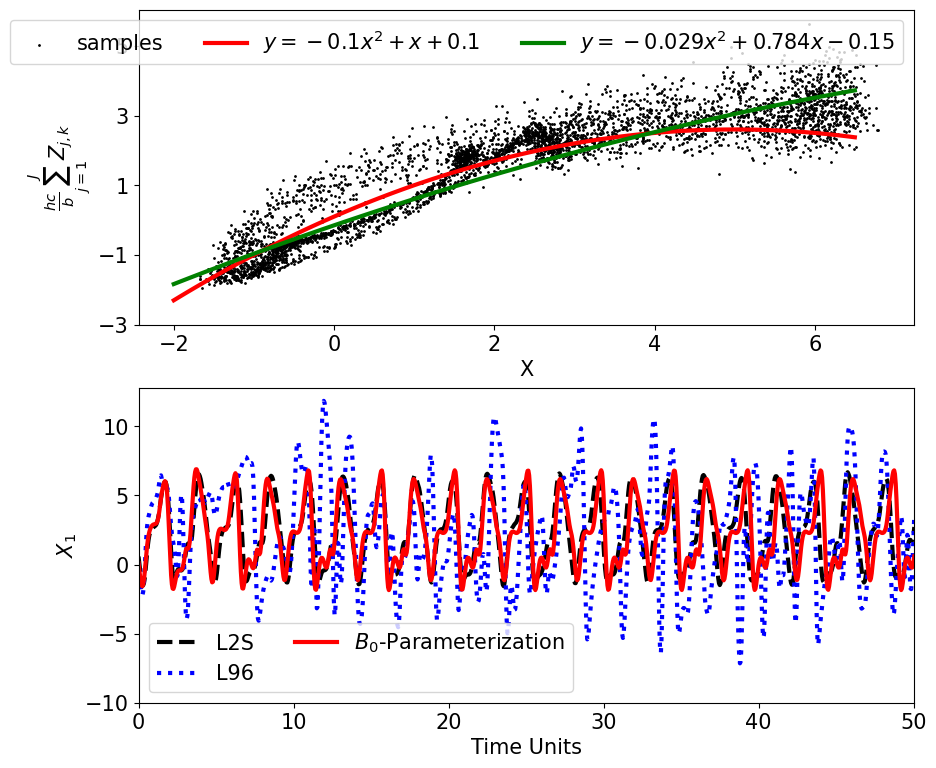

In [59]:
# In[fitting parameter with true data]
# deterministic parameterization for U by 2th order polyfit   
dt = 0.05    # the model step size is dt.     
Nt = int(dt/delta_t)

Xu = Xtrue[range(0,period_steps,Nt)]  # truth for model's temporal resolution
Para_true = np.zeros_like(Xu)
for j in range(2000):
    Z = Ytrue[j*Nt]
    SumZ = np.sum(np.reshape(Z,(K,J)),axis=1)
    Para_true[j] = h*c/b*SumZ

z = np.polyfit(Xu.flatten(),Para_true.flatten(),2)
gU = np.poly1d(z)
xtt = np.linspace(-2,6.5,100)

pC0 = np.array([-0.1,1,0.1])
zU = np.poly1d(pC0)

kU = np.poly1d(np.array([-0.029,0.784,-0.15]))
# plot U again Xu and gU profile
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplot(2,1,1)
plt.scatter(Xu[np.arange(0,1000,2)],Para_true[np.arange(0,1000,2)],s=1,c='k',label='samples')
plt.plot(xtt,zU(xtt),'r',lw = 3,label=r'$y=-0.1x^2+x+0.1$')
plt.plot(xtt,kU(xtt),'g',lw = 3,label=r'$y=-0.029x^2+0.784x-0.15$')
plt.legend(ncol = 3,fontsize=15)
plt.xticks(fontsize=15);plt.yticks(np.arange(-3,7,2),fontsize=15)
plt.xlabel('X',fontsize=15)
plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15)

Xpara = np.zeros_like(Xu)
x0 = x0true[range(K)]
for j in range(len(Xpara)):
    x1 = L96para_adv_1step(x0,dt,F,zU)
    Xpara[j] = x1
    x0 = x1
Xctl = np.zeros_like(Xu)
x0 = x0true[range(K)]
for j in range(len(Xpara)):
    x1 = Lmodel_adv_1step(x0,dt,F)
    Xctl[j] = x1
    x0 = x1

plt.subplot(2,1,2)
plt.plot(np.arange(2000)*dt,Xu[:,0],'k--',lw=3,label='L2S')
plt.plot(np.arange(2000)*dt,Xctl[:,0],color='b',linestyle=':',lw=3,label='L96')
plt.plot(np.arange(2000)*dt,Xpara[:,0],'r-',lw=3,label='$B_0$-Parameterization') 
plt.xlabel('Time Units',fontsize=15)
plt.ylabel(r'$X_1$',fontsize=15)
plt.legend(ncol = 2,fontsize=15)  
plt.xticks(fontsize=15);plt.yticks(np.arange(-10,15,5),fontsize=15)
plt.xlim(0,50)
#plt.savefig(case_dir+'figure1.eps',format='eps')

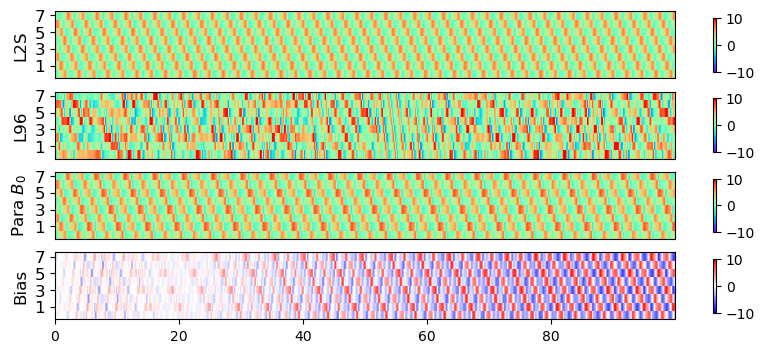

In [6]:
plt.figure(figsize=(10,4))
xx,yy = np.meshgrid(0.05*np.arange(2000),range(8))
pltcmp = plt.cm.rainbow
plt.subplot(4,1,1)
plt.pcolormesh(xx,yy,Xu.T,cmap=pltcmp);plt.clim(-10,10)
plt.ylabel('L2S',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,2)
plt.pcolormesh(xx,yy,Xctl.T,cmap=pltcmp);plt.clim(-10,10)
plt.ylabel('L96',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,3)
plt.pcolormesh(xx,yy,Xpara.T,cmap=pltcmp);plt.clim(-10,10)
plt.ylabel('Para $B_0$',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,4)
plt.pcolormesh(xx,yy,(Xpara-Xu).T,cmap=plt.cm.bwr);plt.clim(-10,10)
plt.ylabel('Bias',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.colorbar(shrink=0.8)

In [7]:
def computeACC(X1,X2):
    clim1 = np.mean(X1,axis=0)
    clim2 = np.mean(X2,axis=0)
    X1_a = X1 - clim1[np.newaxis,:]
    X2_a = X2 - clim2[np.newaxis,:]
    ACC = np.zeros(len(X1))
    for j in range(len(X1)):
        ACC[j] = np.corrcoef(X1_a[j,:],X2_a[j,:])[0,1]
    return ACC

In [8]:
ACCc = computeACC(Xu,Xctl)
ACCp = computeACC(Xu,Xpara)
RMSEc = np.sqrt(np.mean((Xctl-Xu)**2,axis=1))
RMSEp = np.sqrt(np.mean((Xpara-Xu)**2,axis=1))

Text(0.5, 0, 'Time/TUs')

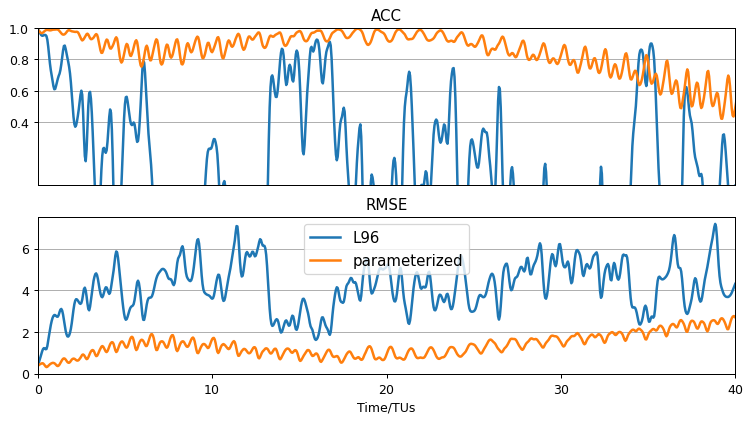

In [11]:
#%%
plt.figure(figsize=(10,5),dpi=90)
plt.subplot(2,1,1)
plt.title('ACC')
plt.plot(dt*np.arange(0,2000),ACCc,lw=2,label="L96")
plt.plot(dt*np.arange(0,2000),ACCp,lw=2,label="parameterized")
plt.xlim(0,40)
plt.ylim(0,1);plt.yticks([0.4,0.6,0.8,1])
plt.grid(axis='y')
plt.xticks([])
plt.subplot(2,1,2)
plt.title('RMSE')
plt.plot(dt*np.arange(0,2000),RMSEc,lw=2,label="L96")
plt.plot(dt*np.arange(0,2000),RMSEp,lw=2,label="parameterized")
plt.xlim(0,40)
plt.grid(axis='y')
plt.legend(fontsize=12)
plt.xticks(np.arange(0,41,10))
plt.xlabel("Time/TUs")

使用2000个数据进行多项式拟合得到的系数大约是：$b_0=0.123$, $b_1=1.04$, $b_2=-0.0879$。为了开展后面的状态和参数估计实验，我们使用更粗糙一点儿的近似系数$B_0=[0.1,1,-0.1]$作为初始参数猜测。图1代表了使用该参数的结果和真实结果的比较，相比于只积分公式1的单尺度模式，参数化的效果能够体现。

就这我还用了完全精确的初值。如果初值有比较大的偏差，那预报水平更低。

In [14]:
Xpred0 = np.zeros_like(Xu)
x0 = x0true[range(K)]+1.5*np.random.randn(8)
for j in range(len(Xpara)):
    x1 = L96para_adv_1step(x0,dt,F,zU)
    Xpred0[j] = x1
    x0 = x1

ACCpred0 = computeACC(Xu,Xpred0)
RMSEpred0 = np.sqrt(np.mean((Xpred0-Xu)**2,axis=1))

Text(0.5, 0, 'Time/TUs')

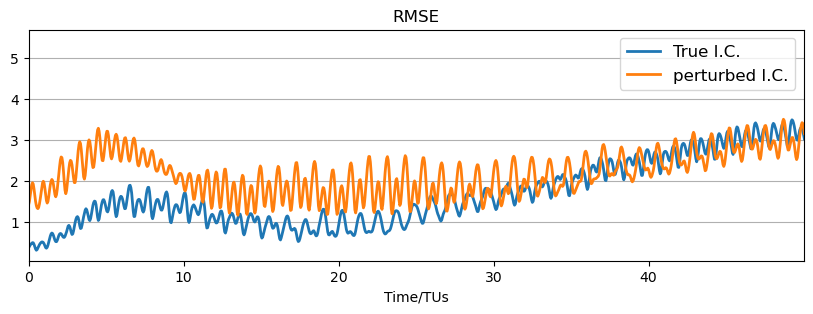

In [16]:
plt.figure(figsize=(10,3))
plt.title('RMSE')
plt.plot(dt*np.arange(0,2000),RMSEp,lw=2,label="True I.C.")
plt.plot(dt*np.arange(0,2000),RMSEpred0,lw=2,label="perturbed I.C.")
plt.xlim(0,50)
plt.grid(axis='y')
plt.legend(fontsize=12)
plt.xticks(np.arange(0,41,10))
plt.xlabel("Time/TUs")

造X变量的观测如下：

In [17]:
# In[create X obs]
assim_period = 2000
obs_every_n_steps = 4;
obs_error_std = 0.5; obs_error_var = obs_error_std**2
def H_op(x,H_mat): 
    y = np.dot(H_mat,np.transpose(x))
    return y
H_mat = np.eye(K)
if not os.path.exists(case_dir+'DATA/MSobs.npz'):
    OBS = np.zeros([assim_period//obs_every_n_steps,K])
    for m in range(assim_period//obs_every_n_steps):
        OBS[m] = H_op(Xu[m*obs_every_n_steps],H_mat)+obs_error_std*np.random.randn(K)
    np.savez(case_dir+'DATA/MSobs.npz',OBS)
else:
    TMP_DAT = np.load(case_dir+'DATA/MSobs.npz')
    OBS = TMP_DAT['arr_0']
    print('load X observation')

load X observation


## 状态估计实验

如果不加入参数估计，使用$B_0$参数化的模式开展状态估计，使用自适应协方差膨胀和调整后的大致最优局地化参数。
先定义同化方法如下：
包括：
支持
1. 自适应inflation的 eakf_analysis
2. 只作用于单个观测点的 eakf_analysis_1obs, 需要在观测循环外做inflation
3. 固定常数inflation的 eakf_analysis_constinf

用于不同场景，1用于SE，2用于PE with target obs.

In [18]:
# In[def EAKF method]
# localization factor
def comp_cov_factor(z_in,c):
    z=abs(z_in);
    if z<=c:
        r = z/c;
        cov_factor=((( -0.25*r +0.5)*r +0.625)*r -5.0/3.0)*r**2 + 1.0;
    elif z>=c*2.0:
        cov_factor=0.0;
    else:
        r = z / c;
        cov_factor = ((((r/12.0 -0.5)*r +0.625)*r +5.0/3.0)*r -5.0)*r + 4.0 - 2.0 / (3.0 * r);
    return cov_factor;
# observation increment for the observation site
def obs_increment_eakf(ensemble, observation, obs_error_var):
    prior_mean = np.mean(ensemble);
    prior_var = np.var(ensemble);
    if prior_var >0.001:
        post_var = 1.0 / (1.0 / prior_var + 1.0 / obs_error_var);
        post_mean = post_var * (prior_mean / prior_var + observation / obs_error_var);
    else:
        post_var = prior_var;
        post_mean = prior_mean;
    
    updated_ensemble = ensemble - prior_mean + post_mean;

    var_ratio = post_var / prior_var;
    updated_ensemble = np.sqrt(var_ratio) * (updated_ensemble - post_mean) + post_mean;

    obs_increments = updated_ensemble - ensemble;
    return obs_increments
# regression the obs_inc to model grid corresponds state_ens
def get_state_increments(state_ens, obs_ens, obs_incs):
    covar = np.cov(state_ens, obs_ens);
    state_incs = obs_incs * covar[0,1]/covar[1,1];
    return state_incs
# the following for adaptive inflation
def compute_new_density(dist_2, sigma_p_2, sigma_o_2, lambda_mean, lambda_sd, gamma, lambda_in):
    exponent_prior = - 0.5 * (lambda_in - lambda_mean)**2 / lambda_sd**2;
    # Compute probability that observation would have been observed given this lambda
    theta_2 = (1.0 + gamma * (np.sqrt(lambda_in) - 1.0))**2 * sigma_p_2 + sigma_o_2;
    theta = np.sqrt(theta_2);    
    exponent_likelihood = dist_2 / ( -2.0 * theta_2);    
    # Compute the updated probability density for lambda
    # Have 1 / sqrt(2 PI) twice, so product is 1 / (2 PI)
    density = np.exp(exponent_likelihood + exponent_prior) / (2.0 * np.pi * lambda_sd * theta);
    return density

def update_inflate(x, sigma_p_2, obs, sigma_o_2, inflate_prior_val, lambda_mean, gamma,lambda_sd):
    lambda_mean_LB = 1.0
    lambda_mean_UB = 1.3
    lambda_sd_LB = 0.5   
    # FIRST, update the inflation mean:
    # Get the "non-inflated" variance of the sample
    # lambda here, is the prior value before the update.
    sigma_p_2 = sigma_p_2/(1+gamma*np.sqrt(inflate_prior_val)-1)**2
    dist_2 = (x - obs)**2        # Squared-innovation
    theta_bar_2 = ( 1 + gamma * (np.sqrt(lambda_mean) - 1) )**2 * sigma_p_2 + sigma_o_2;
    theta_bar    = np.sqrt(theta_bar_2);
    u_bar        = 1 / (np.sqrt(2 * np.pi) * theta_bar);
    like_exp_bar = - 0.5 * dist_2 / theta_bar_2;
    v_bar        = np.exp(like_exp_bar);
    
    gamma_terms  = 1 - gamma + gamma*np.sqrt(lambda_mean);
    dtheta_dinf  = 0.5 * sigma_p_2 * gamma * gamma_terms / (theta_bar * np.sqrt(lambda_mean));
    
    like_bar     = u_bar * v_bar;
    like_prime   = (like_bar * dtheta_dinf / theta_bar) * (dist_2 / theta_bar_2 - 1);
    like_ratio   = like_bar / like_prime;
    
    # Solve a quadratic equation
    a = 1;
    b = like_ratio - 2*lambda_mean;
    c = lambda_mean**2 - lambda_sd**2 - like_ratio*lambda_mean ;
    
    o = np.max( [ np.abs(a), np.abs(b), np.abs(c) ] );
    a = a/o;
    b = b/o;
    c = c/o;
    d = b**2 - 4*a*c;
    if b < 0:
        s1 = 0.5 * ( -b + np.sqrt(d) ) / a;
    else: 
        s1 = 0.5 * ( -b - np.sqrt(d) ) / a;

    s2 = ( c/a ) / s1;
    
    if np.abs(s2 - lambda_mean) < np.abs(s1 - lambda_mean):
        new_cov_inflate = s2;
    else:
        new_cov_inflate = s1;
        
    if new_cov_inflate < lambda_mean_LB or new_cov_inflate > lambda_mean_UB or np.isnan(new_cov_inflate):
        new_cov_inflate = lambda_mean_LB; 
        new_cov_inflate_sd = lambda_sd;
        return new_cov_inflate,new_cov_inflate_sd
    if lambda_sd <= lambda_sd_LB: 
        new_cov_inflate_sd = lambda_sd;
        return new_cov_inflate,new_cov_inflate_sd
    else:
        new_max = compute_new_density(dist_2, sigma_p_2, sigma_o_2, lambda_mean, lambda_sd, gamma, new_cov_inflate);

        # Find value at a point one OLD sd above new mean value
        new_1_sd = compute_new_density(dist_2, sigma_p_2, sigma_o_2, lambda_mean, lambda_sd, gamma, new_cov_inflate + lambda_sd);
    
        ratio = new_1_sd / new_max;
        # Can now compute the standard deviation consistent with this as
        # sigma = sqrt(-x^2 / (2 ln(r))  where r is ratio and x is lambda_sd (distance from mean)
        new_cov_inflate_sd = np.sqrt( - 0.5 * lambda_sd**2 / np.log(ratio) );
    return new_cov_inflate, new_cov_inflate_sd

def eakf_analysis(ensemble_in,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op):
    # 
    inf_cov = 0.6
    N = len(ensemble_in)
    L = len(ensemble_in[0]);     # model dimension (model grids)
    m = len(obs_in);    # number of obs sites
    # prior inflation with inf_in (spatial adaptive)
    ens_mean = np.mean(ensemble_in,axis=0)
    for n in range(N):
        ensemble_in[n] = inf_in*(ensemble_in[n]-ens_mean)+ens_mean
    lambda_i = inf_in.copy()
    for i in range(m):
        ensemble_proj = H_op(ensemble_in,H_mat); 
        obs_proj = ensemble_proj[i];   # project model grid to obs site
        obs_inc = obs_increment_eakf(obs_proj,obs_in[i],obs_error_var);
        for j in range(L):
#            state_inc=get_state_increments(ensemble_in[:,j],obs_proj,obs_inc);
            covar = np.cov(ensemble_in[:,j], obs_proj);
            r = covar[0,1]/covar[1,1]

            cov_factor = LOC_MAT[j,i]                   
#             update inf
            if r*cov_factor>0.0001:
                lambda_i[j], new_cov_inf_sd = update_inflate(np.mean(obs_proj), np.var(obs_proj), obs_in[i], obs_error_var,inf_in[j], lambda_i[j], r*cov_factor,inf_cov)
            # update ensemble
            if r*cov_factor>0:
                ensemble_in[:,j]=ensemble_in[:,j]+r*cov_factor*obs_inc;    
    ensemble_out = ensemble_in;
    inf_out = lambda_i
    #inf_out = inf_in 
    return ensemble_out,inf_out

def eakf_analysis_1obs(ensemble_in,obs_in,obs_error_var,H_mat,LOC_MAT,H_op):
    # use LOC_MAT, convient for CDA
    # inflation outside the function
    # for only 1 observation
    L = len(ensemble_in[0]);     # model dimension (model grids)
    ensemble_proj = H_op(ensemble_in,H_mat); 
    obs_proj = ensemble_proj;   # project model grid to obs site
    obs_inc = obs_increment_eakf(obs_proj,obs_in,obs_error_var);
    for j in range(L):
        covar = np.cov(ensemble_in[:,j], obs_proj);
        if covar[1,1]>0.001:
            r = covar[0,1]/covar[1,1]
        else:
            r=0
        cov_factor = LOC_MAT[j]                   
        # update ensemble
        if cov_factor>0:
            ensemble_in[:,j]=ensemble_in[:,j]+r*cov_factor*obs_inc;   
    ensemble_out = ensemble_in;
    return ensemble_out    
def eakf_analysis_constinf(ensemble_in,obs_in,obs_error_var,H_mat,LOC_MAT,H_op):
    # N = len(ensemble_in)
    L = len(ensemble_in[0]);     # model dimension (model grids)
    m = len(obs_in);    # number of obs sites
    # prior inflation not inside the analysis step
    # ens_mean = np.mean(ensemble_in,axis=0)
    # for n in range(N):
    #     ensemble_in[n] = inf_in*(ensemble_in[n]-ens_mean)+ens_mean
    for i in range(m):
        ensemble_proj = H_op(ensemble_in,H_mat); 
        obs_proj = ensemble_proj[i];   # project model grid to obs site
        obs_inc = obs_increment_eakf(obs_proj,obs_in[i],obs_error_var);
        for j in range(L):
            covar = np.cov(ensemble_in[:,j], obs_proj);
            r = covar[0,1]/covar[1,1]
            cov_factor = LOC_MAT[j,i]
            # update ensemble
            if cov_factor>0:
                ensemble_in[:,j]=ensemble_in[:,j]+r*cov_factor*obs_inc;    
    ensemble_out = ensemble_in;
    return ensemble_out

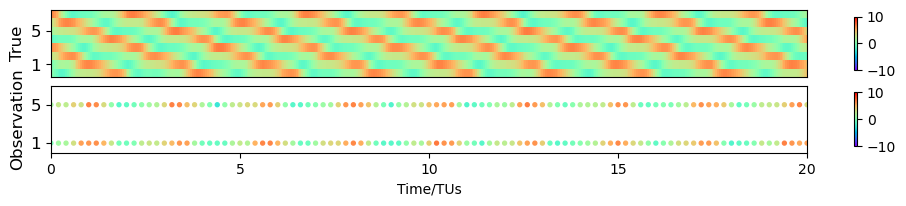

In [20]:
xx,yy = np.meshgrid(0.05*np.arange(2000),range(8))
plt.figure(figsize=(10,2))
plt.subplot(2,1,1)
pltcmp = plt.cm.rainbow
plt.pcolormesh(xx,yy,Xu.T,cmap=pltcmp);plt.clim(-10,10)
plt.ylabel('True',fontsize=12);plt.yticks([1,5],fontsize=12)
plt.xlim(0,20)
plt.xticks([])
plt.colorbar(shrink=0.8)
xo,to = np.meshgrid(dt*np.arange(0,2000,4),[1,5])
obs_plt = OBS[:,[1,5]]
xoo = xo.reshape(-1);
too = to.reshape(-1);
obso = obs_plt.T.reshape(-1)
plt.subplot(2,1,2)
plt.scatter(xoo,too,s=8,c=obso,cmap=plt.cm.rainbow)
plt.ylabel('Observation',fontsize=12)
plt.clim(-10,10);plt.ylim(0,7);plt.yticks([1,5],fontsize=12)
plt.xlim(0,20);plt.xticks(np.arange(0,21,5))
plt.colorbar(shrink=0.8)
plt.xlabel("Time/TUs")
#plt.savefig('fig4.png')
plt.tight_layout(pad=0.5)

集合同化初值

In [21]:
Ne = 30
if not os.path.exists(case_dir+'INITENS/INITENS'+str(Ne)+'.npz'):
    X0 = np.zeros([Ne,K])
    for n in range(Ne):
        X0[n] = OBS[0]+2*np.random.randn(K)
    np.savez(case_dir+'INITENS/INITENS'+str(Ne)+'.npz',X0)
else:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];

开始状态估计

In [22]:
pC0 = np.array([-0.1,1,0.1]) # with fixed parameters
LOC_MAT = np.ones([K,K])  # no localization
# apply localization
local_para = 0.5
for i in range(K):
    for j in range(K):
        dist = np.abs(i-j);
        if dist>K/2.0:
            dist=K-dist;
        LOC_MAT[i,j] = comp_cov_factor(dist,local_para);
# SE experiment with full observation as follow
if not os.path.exists(case_dir+'output/se_result_loc'+str(local_para)+'.npz'):
#if True:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Ens = X0; Ens2 = np.zeros_like(Ens)
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    for t in range(assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,F,pC0)
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
    #     # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;inf_in = inf_out
    np.savez(case_dir+'output/se_result_loc'+str(local_para)+'.npz',Xassim,\
             Xspread,preassm_mean,preassm_std,postassm_mean,postassm_std,inf_factors)
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))
else:
    TMP = np.load(case_dir+'output/se_result_loc'+str(local_para)+'.npz')
    Xassim=TMP['arr_0'];Xspread=TMP['arr_1'];preassm_mean=TMP['arr_2']
    preassm_std=TMP['arr_3'];postassm_mean=TMP['arr_4'];postassm_std=TMP['arr_5'];
    inf_factors=TMP['arr_6'];
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.331
mean RMSS = 0.173


| Localization | <0.5  | 1     | 2     | 4     | 8     | 16    | 32    |
| ------------ | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| RMSE         | 0.331 | 0.383 | 0.402 | 0.441 | 0.480 | 0.453 | 0.470 |
| RMSS         | 0.173 | 0.153 | 0.143 | 0.135 | 0.134 | 0.136 | 0.134 |

关于局地化参数的选择，见表1

画状态估计的结果图(可能不直接用在论文里)

([<matplotlib.axis.YTick at 0x107683860>,
 [Text(0, 0, '0'), Text(0, 2, '2'), Text(0, 4, '4'), Text(0, 6, '6')])

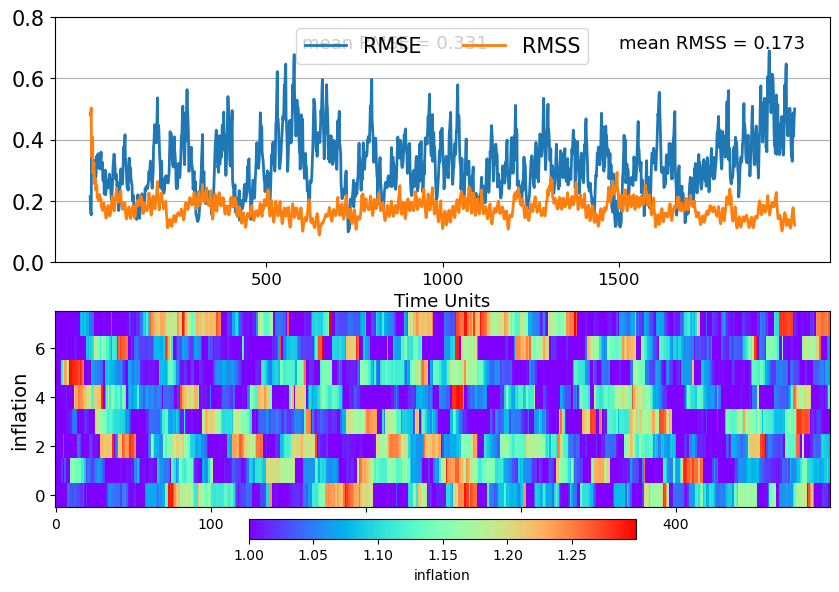

In [23]:
# plt1 rmse
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(rmse,label='RMSE',lw=2)
plt.plot(rmss,label='RMSS',lw=2)
plt.legend(ncol = 3,fontsize=15)
plt.xticks(fontsize=15);plt.yticks(np.arange(-0,1,0.2),fontsize=15)
plt.grid(axis='y')
plt.text(600, 0.7, 'mean RMSE = %.3f'%np.mean(rmse[500::]),fontsize=13)
plt.text(1500, 0.7, 'mean RMSS = %.3f'%np.mean(rmss[500::]),fontsize=13)
plt.xticks(range(500,2000,500),fontsize=12)
plt.xlabel('Time Units',fontsize=13)
plt.subplot(2,1,2)
xx,yy = np.meshgrid(range(500),range(8))
pltcmp = plt.cm.rainbow
plt.pcolormesh(xx,yy,inf_factors.T,cmap=pltcmp);
plt.colorbar(orientation='horizontal',shrink=0.5,pad=0.05,label='inflation')
plt.ylabel('inflation',fontsize=14);plt.yticks([0,2,4,6],fontsize=12)

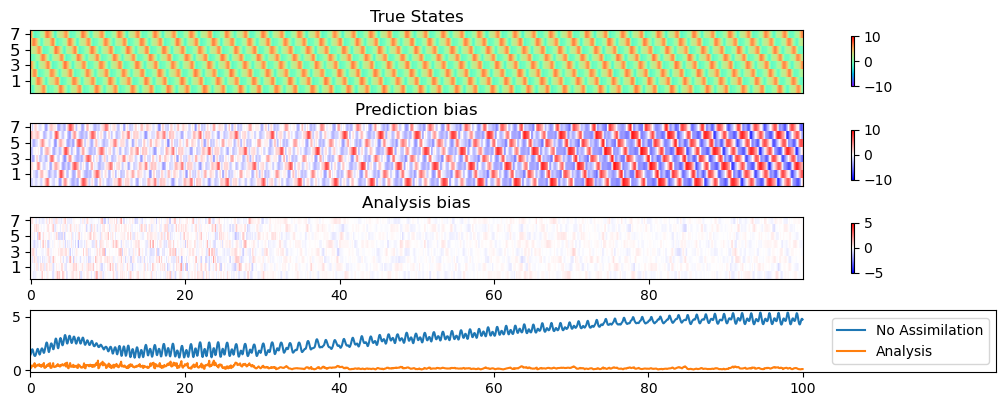

In [56]:
plt.figure(figsize=(10,4))
xx,yy = np.meshgrid(0.05*np.arange(2000),range(8))
pltcmp = plt.cm.rainbow
plt.subplot(4,1,1)
plt.pcolormesh(xx,yy,Xu.T,cmap=pltcmp);plt.clim(-10,10)
plt.title('True States',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,2)
plt.pcolormesh(xx,yy,(Xpred0-Xu).T,cmap=plt.cm.bwr);plt.clim(-10,10)
plt.title('Prediction bias',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,3)
plt.pcolormesh(xx,yy,(Xassim-Xu).T,cmap=plt.cm.bwr);plt.clim(-5,5)
plt.title('Analysis bias',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks()
plt.colorbar(shrink=0.8)
plt.yticks([1,3,5,7],fontsize=12)
plt.subplot(4,1,4)
plt.plot(0.05*np.arange(2000),RMSEpred0,label='No Assimilation')
plt.plot(0.05*np.arange(2000),rmse,label="Analysis")
plt.legend(loc='right')
plt.xlim(0,125);plt.xticks(range(0,101,20))
plt.tight_layout(pad=0.5)

以下进行PE，为了使用相同的参数集合，先统一扰动生成参数集合

In [25]:
pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
PCs0 = np.ones([Ne,3])
if not os.path.exists(case_dir+'INITENS/paraensens'+str(Ne)+'.npz'):
    for j in range(Ne):      # intial perturbation of coefficients
        PCs0[j] = pC0+pCstd*np.random.randn(3)    
    np.savez(case_dir+'INITENS/paraensens'+str(Ne)+'.npz',PCs0)
else:
    TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
    PCs0 = TMP_DAT['arr_0'];


进行固定使用两个观测估计参数的参数估计实验，先进行一段时间（500步）的纯状态估计，但是使用扰动的参数集合积分模式。当开启参数估计（500步以后）后，每步同化先使用全部观测做状态估计，然后使用其中两个观测进行参数估计。

In [26]:
if not os.path.exists(case_dir+'output/pe_result_fix2.npz'):
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
    TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
    PCs0 = TMP_DAT['arr_0'];
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    
    PCassim_mean = np.zeros([ana_steps,3])
    PCassim_std = np.zeros([ana_steps,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    para_inf = 1.02
    #
    
    LOC_MAT_SE = np.ones([K,K])  # no localization
    # apply localization
    local_para = 0.5
    for i in range(K):
        for j in range(K):
            dist = np.abs(i-j);
            if dist>K/2.0:
                dist=K-dist;
            LOC_MAT_SE[i,j] = comp_cov_factor(dist,local_para);
            
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT_SE,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            PCassim_mean[tassim] = np.mean(PCs,axis=0)
            PCassim_std[tassim] = np.std(PCs,axis=0)
            
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2            
                    
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out
    # activate PE 
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            
            PCs_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = para_inf*(PCs[n]-PCs_mean)+PCs_mean
                
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)            
            # Ens_ext = eakf_analysis_constinf(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op)
            for i in [1,5]:                
                H_i = H_mat_ext[i,:]
                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[i],obs_error_var,H_i,LOC_MAT_ext[:,i],H_op); 
            
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            
            PCs = Ens_ext[:,range(K,K+3)]
            PCassim_mean[tassim]=np.mean(PCs,axis=0)
            PCassim_std[tassim]=np.std(PCs,axis=0)
            
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2    
            
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out     
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))
    np.savez(case_dir+'output/pe_result_fix2.npz',Xassim,Xspread,preassm_mean,\
             preassm_std,postassm_mean,postassm_std,inf_factors,PCassim_mean,PCassim_std,\
            Xassim_ana,PCassim_ana)
else:
    TMP = np.load(case_dir+'output/pe_result_fix2.npz')
    Xassim=TMP['arr_0'];Xspread=TMP['arr_1'];preassm_mean=TMP['arr_2']
    preassm_std=TMP['arr_3'];postassm_mean=TMP['arr_4'];postassm_std=TMP['arr_5'];
    inf_factors=TMP['arr_6'];PCassim_mean=TMP['arr_7'];
    PCassim_std=TMP['arr_8'];
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.222
mean RMSS = 0.182


然后对每次的参数估计计算TVR。使用TVR最大的两个进行参数估计。先定义TVR的计算方式如下（主要创新）：

In [27]:
#%% tools I developed for variance reductions
def r2theta(Ens_in, obs_error_var, H_op, H_mat):
    Ens_proj = H_op(Ens_in,H_mat);   # L dimensional
    L = len(Ens_in[0])
    sigma_pri2 = np.var(Ens_proj)
    theta = sigma_pri2/(sigma_pri2+obs_error_var)
    rxy = np.zeros(L)
    for j in range(L):
        cv = np.corrcoef(Ens_in[:,j],Ens_proj)
        rxy[j]=cv[0,1]
    r2theta = rxy**2*theta
    return r2theta
def comp_vr(Ens_in,obs_error_var,Hop,H_mat):
    L = len(Ens_in[0])
    R2T = np.zeros([L,K])  # row for dimension, column for obs
    for i in range(K):   # for each potential observation site
        R2T[:,i] = r2theta(Ens_in,obs_error_var,H_op,H_mat[i,:])
    SIG = np.var(Ens_in,axis=0)
    VR = R2T*np.tile(SIG,(K,1)).T
    return VR
def max_index(tvr,current_idx):
    tpvr = tvr.copy()
    tpvr[current_idx] = np.nan
    idx1 = np.nanargmax(tpvr)
    return idx1

开始参数估计

In [28]:
if not os.path.exists(case_dir+'output/pe_result_adaptive2.npz'):
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
    TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
    PCs0 = TMP_DAT['arr_0'];
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_mean = np.zeros([ana_steps,3])
    PCassim_std = np.zeros([ana_steps,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
        
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    para_inf = 1.02
    #
    LOC_MAT_SE = np.ones([K,K])  # no localization
    # apply localization
    local_para = 0.5
    for i in range(K):
        for j in range(K):
            dist = np.abs(i-j);
            if dist>K/2.0:
                dist=K-dist;
            LOC_MAT_SE[i,j] = comp_cov_factor(dist,local_para);
            
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    INDICES = np.zeros([500,2])
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT_SE,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            PCassim_mean[tassim]=np.mean(PCs,axis=0)
            PCassim_std[tassim]=np.std(PCs,axis=0)
            
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2
            
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out
    # activate PE 
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            
            PCs_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = para_inf*(PCs[n]-PCs_mean)+PCs_mean
                
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)            
            # Ens_ext = eakf_analysis_constinf(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op)
            opt_idx=[]
            for i in range(2):
                VR = comp_vr(Ens_ext, obs_error_var, H_op, H_mat_ext)
                tvr = np.sum(VR[8::,:],axis=0)
                idx1 = max_index(tvr, opt_idx)
                opt_idx.append(idx1)
                H_i = H_mat_ext[idx1,:]

                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[idx1],obs_error_var,H_i,LOC_MAT_ext[:,idx1],H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            INDICES[tassim]=opt_idx
            PCs = Ens_ext[:,range(K,K+3)]
            PCassim_mean[tassim]=np.mean(PCs,axis=0)
            PCassim_std[tassim]=np.std(PCs,axis=0)
            
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2
            
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out     
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))
    np.savez(case_dir+'output/pe_result_adaptive2.npz',Xassim,Xspread,preassm_mean,\
             preassm_std,postassm_mean,postassm_std,inf_factors,PCassim_mean,PCassim_std,\
             Xassim_ana,PCassim_ana,INDICES)
else:
    TMP = np.load(case_dir+'output/pe_result_adaptive2.npz')
    Xassim=TMP['arr_0'];Xspread=TMP['arr_1'];preassm_mean=TMP['arr_2']
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.190
mean RMSS = 0.154


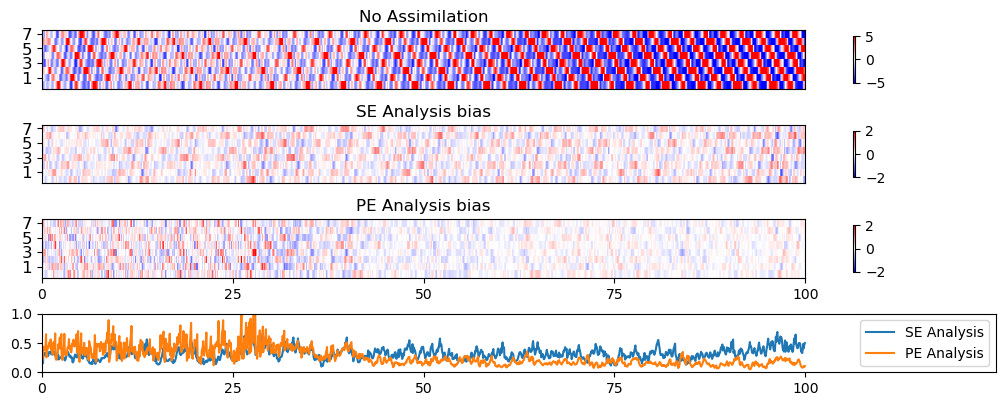

In [57]:
TMP = np.load(case_dir+'output/se_result_loc0.5.npz')
Xassim_SE = TMP['arr_0'];Xspread_SE=TMP['arr_1']
rmseSE = np.sqrt(np.mean(np.square(Xassim_SE-Xu),axis=1))
rmssSE = np.sqrt(np.mean(np.square(Xspread_SE),axis=1))
TMP = np.load(case_dir+'output/pe_result_fix2.npz')
Xassim_fix = TMP['arr_0'];Xspread_fix=TMP['arr_1']
rmsefix = np.sqrt(np.mean(np.square(Xassim_fix-Xu),axis=1))
rmssfix = np.sqrt(np.mean(np.square(Xspread_fix),axis=1))
plt.figure(figsize=(10,4))
xx,yy = np.meshgrid(0.05*np.arange(2000),range(8))
pltcmp = plt.cm.rainbow
plt.subplot(4,1,1)
plt.pcolormesh(xx,yy,(Xpred0-Xu).T,cmap=plt.cm.bwr);plt.clim(-5,5)
plt.title('No Assimilation',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,2)
plt.pcolormesh(xx,yy,(Xassim_SE-Xu).T,cmap=plt.cm.bwr);plt.clim(-2,2)
plt.title('SE Analysis bias',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks([])
plt.colorbar(shrink=0.8)
plt.subplot(4,1,3)
plt.pcolormesh(xx,yy,(Xassim_fix-Xu).T,cmap=plt.cm.bwr);plt.clim(-2,2)
plt.title('PE Analysis bias',fontsize=12);plt.yticks([1,3,5,7],fontsize=12)
plt.xticks(range(0,101,25))
plt.colorbar(shrink=0.8)
plt.yticks([1,3,5,7],fontsize=12)
plt.subplot(4,1,4)
plt.plot(0.05*np.arange(2000),rmseSE,label="SE Analysis")
plt.plot(0.05*np.arange(2000),rmsefix,label="PE Analysis")
plt.legend(loc='right')
plt.ylim(0,1)
plt.xlim(0,125);plt.xticks(range(0,101,25))
plt.tight_layout(pad=0.5)

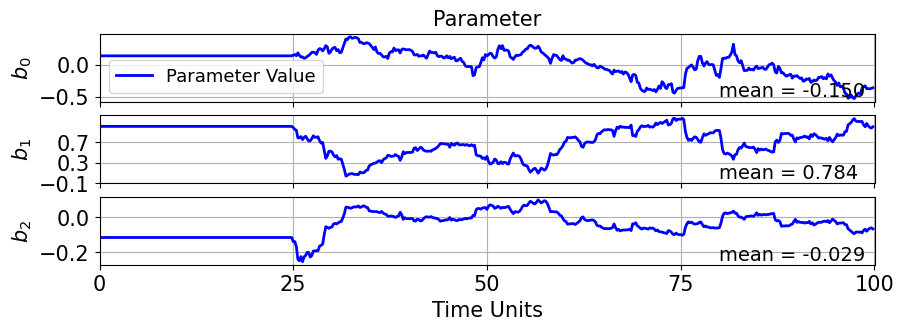

In [58]:
TMP = np.load(case_dir+'output/pe_result_fix2.npz')
PCfix_mean=TMP['arr_7'];PCfix_std=TMP['arr_8'];
plt.figure(figsize=(10,3))
plt.subplot(3,1,1)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_mean[:,2],'b',lw=2,label='Parameter Value')
plt.xticks([0,25,50,75,100],[],fontsize=15);plt.xlim(0,100.01)
plt.ylabel(r'$b_0$',fontsize=15);plt.yticks(fontsize=15)
plt.text(80,-0.5,"mean = %.3f"%np.mean(PCfix_mean[375::,2]),fontsize=14)
plt.grid();plt.legend(ncol=4,fontsize=13)
plt.title('Parameter',fontsize=15)
plt.subplot(3,1,2)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_mean[:,1],'b',lw=2,label='Exp-PEf')
plt.xticks([0,25,50,75,100],[],fontsize=15);plt.xlim(0,100.01)
plt.text(80,0,"mean = %.3f"%np.mean(PCfix_mean[375::,1]),fontsize=14)
plt.ylabel(r'$b_1$',fontsize=15);plt.yticks([-0.1,0.3,0.7],fontsize=15)
plt.grid()
plt.subplot(3,1,3)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_mean[:,0],'b',lw=2,label='Exp-PEf')
plt.xticks([0,25,50,75,100],fontsize=15);plt.xlim(0,100.01)
plt.ylabel(r'$b_2$',fontsize=15);plt.yticks(fontsize=15)
plt.text(80,-0.25,"mean = %.3f"%np.mean(PCfix_mean[375::,0]),fontsize=14)
plt.xlabel('Time Units',fontsize=15)
plt.grid()

In [52]:
kU = np.poly1d(np.array([-0.029,0.784,-0.15]))
Xpara2 = np.zeros_like(Xu)
x0 = x0true[range(K)]
for j in range(len(Xpara2)):
    x1 = L96para_adv_1step(x0,dt,F,kU)
    Xpara2[j] = x1
    x0 = x1
ACCp2 = computeACC(Xu,Xpara2)
RMSEp2 = np.sqrt(np.mean((Xpara2-Xu)**2,axis=1))

Text(0.5, 0, 'Time/TUs')

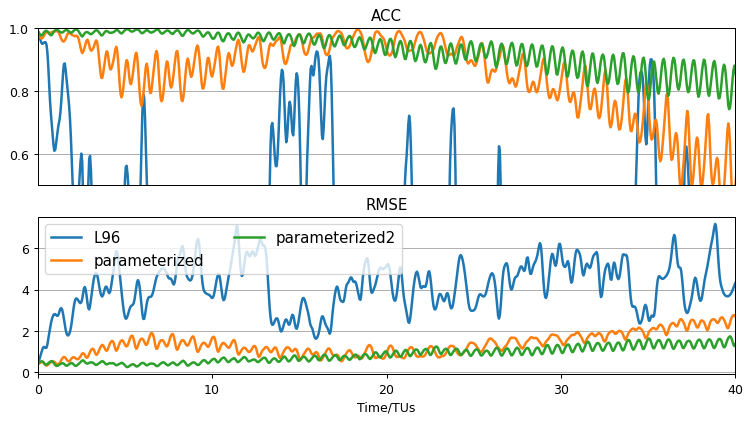

In [55]:
plt.figure(figsize=(10,5),dpi=90)
plt.subplot(2,1,1)
plt.title('ACC')
plt.plot(dt*np.arange(0,2000),ACCc,lw=2,label="L96")
plt.plot(dt*np.arange(0,2000),ACCp,lw=2,label="parameterized")
plt.plot(dt*np.arange(0,2000),ACCp2,lw=2,label="parameterized2")
plt.xlim(0,40)
plt.ylim(0.5,1);plt.yticks([0.6,0.8,1])
plt.grid(axis='y')
plt.xticks([])
plt.subplot(2,1,2)
plt.title('RMSE')
plt.plot(dt*np.arange(0,2000),RMSEc,lw=2,label="L96")
plt.plot(dt*np.arange(0,2000),RMSEp,lw=2,label="parameterized")
plt.plot(dt*np.arange(0,2000),RMSEp2,lw=2,label="parameterized2")
plt.xlim(0,40)
plt.grid(axis='y')
plt.legend(fontsize=12,ncol=2)
plt.xticks(np.arange(0,41,10))
plt.xlabel("Time/TUs")

<ipython-input-18-49ab7ad8bee8>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,(Xassim_SE1[:,range(9)]-Xu1[:,range(9)]).T,cmap=pltcmp);plt.clim(-1.5,1.5)
<ipython-input-18-49ab7ad8bee8>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,(Xassim_fix1[:,range(9)]-Xu1[:,range(9)]).T,cmap=pltcmp);plt.clim(-1.5,1.5)
<ipython-input-18-49ab7ad8bee8>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the sa

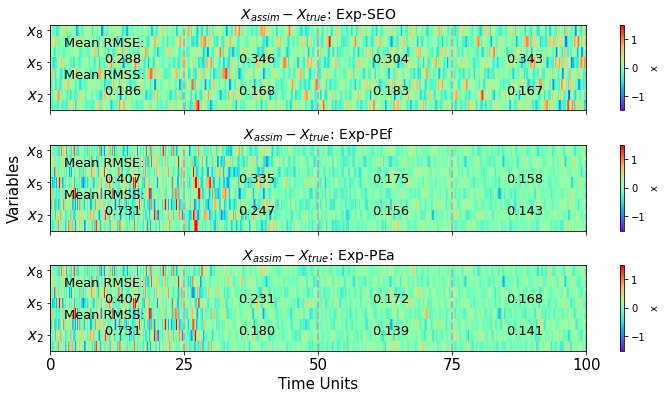

In [18]:
if True:
    TMP = np.load(case_dir+'output/se_result_loc0.5.npz')
    Xassim_SE = TMP['arr_0'];Xspread_SE=TMP['arr_1']
    rmseSE = np.sqrt(np.mean(np.square(Xassim_SE-Xu),axis=1))
    rmssSE = np.sqrt(np.mean(np.square(Xspread_SE),axis=1))
    TMP = np.load(case_dir+'output/pe_result_fix2.npz')
    Xassim_fix = TMP['arr_0'];Xspread_fix=TMP['arr_1']
    rmsefix = np.sqrt(np.mean(np.square(Xassim_fix-Xu),axis=1))
    rmssfix = np.sqrt(np.mean(np.square(Xspread_fix),axis=1))
    TMP = np.load(case_dir+'output/pe_result_adaptive2.npz')
    Xassim_adp = TMP['arr_0'];Xspread_adp=TMP['arr_1']
    rmseadp = np.sqrt(np.mean(np.square(Xassim_adp-Xu),axis=1))
    rmssadp = np.sqrt(np.mean(np.square(Xspread_adp),axis=1))
    xx,yy = np.meshgrid(range(2000),range(9))
    Xu1 = np.concatenate((Xu,Xu),axis=1)
    Xassim_SE1 = np.concatenate((Xassim_SE,Xassim_SE),axis=1)
    Xassim_fix1 = np.concatenate((Xassim_fix,Xassim_fix),axis=1)
    Xassim_adp1 = np.concatenate((Xassim_adp,Xassim_adp),axis=1)
    pltcmp = plt.cm.rainbow
    plt.figure(figsize=(12,6))
    plt.subplot(3,1,1)
    plt.pcolormesh(xx,yy,(Xassim_SE1[:,range(9)]-Xu1[:,range(9)]).T,cmap=pltcmp);plt.clim(-1.5,1.5)
    plt.xticks([0,500,1000,1500,2000],[],fontsize=12)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.colorbar(label='x')
    plt.title('$X_{assim}-X_{true}$: Exp-SEO',fontsize=14)
    plt.grid(axis='x',lw=2,ls='--')
    plt.text(50,6,'Mean RMSE:',fontsize=13)
    plt.text(50,3,'Mean RMSS:',fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,4.5,'%.3f'%np.mean(rmseSE[range(j-500,j)]),fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,1.5,'%.3f'%np.mean(rmssSE[range(j-500,j)]),fontsize=13)
    plt.subplot(3,1,2)
    plt.pcolormesh(xx,yy,(Xassim_fix1[:,range(9)]-Xu1[:,range(9)]).T,cmap=pltcmp);plt.clim(-1.5,1.5)
    plt.colorbar(label='x')
    plt.xticks([0,500,1000,1500,2000],[],fontsize=12)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.title('$X_{assim}-X_{true}$: Exp-PEf',fontsize=14)
    plt.grid(axis='x',lw=2,ls='--')
    plt.ylabel('Variables',fontsize=15)
    plt.text(50,6,'Mean RMSE:',fontsize=13)
    plt.text(50,3,'Mean RMSS:',fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,4.5,'%.3f'%np.mean(rmsefix[range(j-500,j)]),fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,1.5,'%.3f'%np.mean(rmssfix[range(j-500,j)]),fontsize=13)

    plt.subplot(3,1,3)
    plt.pcolormesh(xx,yy,(Xassim_adp1[:,range(9)]-Xu1[:,range(9)]).T,cmap=pltcmp);plt.clim(-1.5,1.5)
    plt.colorbar(label='x')
    plt.xticks([0,500,1000,1500,2000],[0,25,50,75,100],fontsize=15)
    plt.xlabel('Time Units',fontsize=15)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.title('$X_{assim}-X_{true}$: Exp-PEa',fontsize=14)
    plt.text(50,6,'Mean RMSE:',fontsize=13)
    plt.text(50,3,'Mean RMSS:',fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,4.5,'%.3f'%np.mean(rmseadp[range(j-500,j)]),fontsize=13)
    for j in range(500,2500,500):
        plt.text(j-300,1.5,'%.3f'%np.mean(rmssadp[range(j-500,j)]),fontsize=13)

    plt.subplots_adjust(wspace=None, hspace=0.4)
    plt.grid(axis='x',lw=2,ls='--')

状态场的估计结果说明了PE相比于SE的优势，以及自适应的方法在开始参数估计之后，能尽快地达成效果。

<ipython-input-19-304d6d57c838>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,inf_SE1.T,cmap=pltcmp);plt.clim(1,1.3)
<ipython-input-19-304d6d57c838>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,inf_fix1.T,cmap=pltcmp);plt.clim(1,1.3)
<ipython-input-19-304d6d57c838>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners 

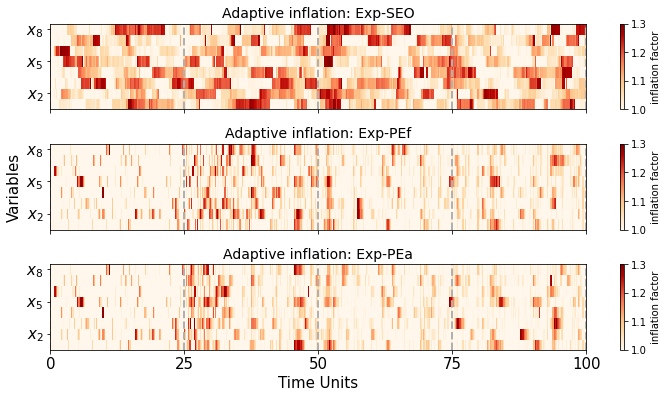

In [19]:
if True:
    TMP = np.load(case_dir+'output/se_result_loc0.5.npz')
    inf_SE = TMP['arr_6']
    TMP = np.load(case_dir+'output/pe_result_fix2.npz')
    inf_fix = TMP['arr_6']
    TMP = np.load(case_dir+'output/pe_result_adaptive2.npz')
    inf_adp = TMP['arr_6']
    inf_SE1 = np.concatenate((inf_SE,inf_SE),axis=1)
    inf_SE1 = inf_SE1[:,range(9)]
    inf_fix1 = np.concatenate((inf_fix,inf_fix),axis=1)
    inf_fix1 = inf_fix1[:,range(9)]
    inf_adp1 = np.concatenate((inf_adp,inf_adp),axis=1)
    inf_adp1 = inf_adp1[:,range(9)]
    #
    xx,yy = np.meshgrid(range(0,2000,obs_every_n_steps),range(9))
    pltcmp = plt.cm.OrRd
    plt.figure(figsize=(12,6))
    plt.subplot(3,1,1)
    plt.pcolormesh(xx,yy,inf_SE1.T,cmap=pltcmp);plt.clim(1,1.3)
    plt.xticks([0,500,1000,1500,2000],[],fontsize=12)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.colorbar(label='inflation factor')
    plt.title('Adaptive inflation: Exp-SEO',fontsize=14)
    plt.grid(axis='x',lw=2,ls='--')

    plt.subplot(3,1,2)
    plt.pcolormesh(xx,yy,inf_fix1.T,cmap=pltcmp);plt.clim(1,1.3)
    plt.colorbar(label='inflation factor')
    plt.xticks([0,500,1000,1500,2000],[],fontsize=12)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.title('Adaptive inflation: Exp-PEf',fontsize=14)
    plt.grid(axis='x',lw=2,ls='--')
    plt.ylabel('Variables',fontsize=15)
 
    plt.subplot(3,1,3)
    plt.pcolormesh(xx,yy,inf_adp1.T,cmap=pltcmp);plt.clim(1,1.3)
    plt.colorbar(label='inflation factor');
    plt.xticks([0,500,1000,1500,2000],[0,25,50,75,100],fontsize=15)
    plt.xlabel('Time Units',fontsize=15)
    plt.yticks([1.5,4.5,7.5],['$x_2$','$x_5$','$x_8$'],fontsize=15)
    plt.title('Adaptive inflation: Exp-PEa',fontsize=14)

    plt.subplots_adjust(wspace=None, hspace=0.4)
    plt.grid(axis='x',lw=2,ls='--')

在全部实验的状态估计部分都采用了自适应的Inflation，可以看自适应的inflation数值，由于参数的扰动本身带来spread，参数估计不需要很大的inflation，而且参数估计打开后，参数spread迅速下降，后面的inflation也不需要很大

<ipython-input-20-f27d589147ae>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,Xu[range(500,1000,4)].T,cmap=pltcmp);plt.clim(-5,5)
<ipython-input-20-f27d589147ae>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xxx,yyy,Ytrue[range(5000,10000,40)].T,cmap=pltcmp);plt.clim(-0.5,0.5)


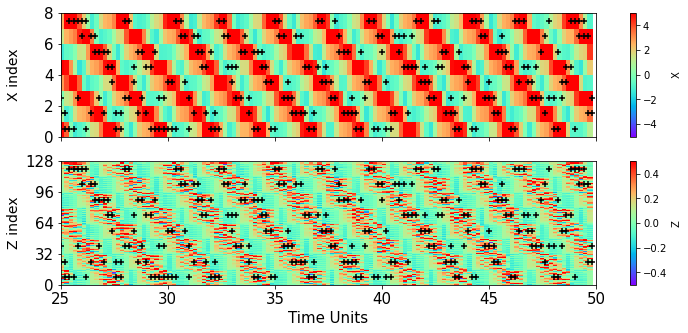

In [20]:
if True:
    TMP = np.load(case_dir+'output/pe_result_adaptive2.npz')
    INDICES=TMP['arr_11'];
    xx,yy = np.meshgrid(range(500,1000,4),range(0,9))
    pltcmp = plt.cm.rainbow
    fig=plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.pcolormesh(xx,yy,Xu[range(500,1000,4)].T,cmap=pltcmp);plt.clim(-5,5)
    plt.colorbar(label='X')
    plt.ylabel('X index',fontsize=14);plt.yticks([0,2,4,6,8],fontsize=15)
    plt.scatter(range(500,1000,4),INDICES[range(125,250),0]+0.5,s=30,marker='+',c='black')
    plt.scatter(range(500,1000,4),INDICES[range(125,250),1]+0.5,s=30,marker='+',c='black')
    plt.xticks(range(500,1100,100),[],fontsize=15)
    
    plt.subplot(2,1,2)
    xxx,yyy = np.meshgrid(range(5000,10000,40),range(0,8*16))
    plt.pcolormesh(xxx,yyy,Ytrue[range(5000,10000,40)].T,cmap=pltcmp);plt.clim(-0.5,0.5)
    plt.colorbar(label='Z')
    plt.ylabel('Z index',fontsize=14);plt.yticks([0,32,64,96,128],fontsize=15);plt.ylim(0,128)
    plt.scatter(range(5000,10000,40),INDICES[range(125,250),0]*16+8,s=30,marker='+',c='black')
    plt.scatter(range(5000,10000,40),INDICES[range(125,250),1]*16+8,s=30,marker='+',c='black')
    plt.xticks(range(5000,11000,1000),range(25,55,5),fontsize=15)
    plt.xlabel('Time Units',fontsize=15)
    fig.align_labels()
    #plt.savefig(case_dir+'figure5.eps',format='eps')

观测点的位置和模式状态场数值大小的比较能说明一些问题：图中画了第500步(参数估计打开)开始的100个同化循环，可以发现最优观测点的位置很大程度上和模式变量值的较大值区一致。X变量数值较大的区域，是Z变量的活跃区，其数值变率较大。所以显然这些区域对应的参数化误差较大，类似地，参数的不确定性较大。

全观测的PE

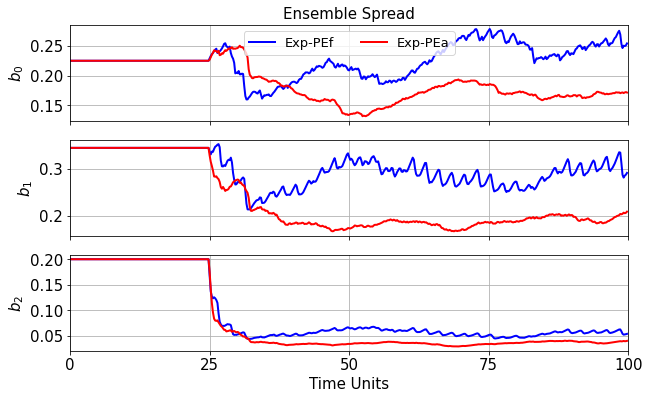

In [21]:
if True:
    TMP = np.load(case_dir+'output/pe_result_fix2.npz')
    PCfix_mean=TMP['arr_7'];PCfix_std=TMP['arr_8'];
    TMP = np.load(case_dir+'output/pe_result_adaptive2.npz')
    PCadp_mean=TMP['arr_7'];PCadp_std=TMP['arr_8'];
    plt.figure(figsize=(10,6))
    plt.subplot(3,1,1)
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_std[:,2],'b',lw=2,label='Exp-PEf')
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCadp_std[:,2],'r',lw=2,label='Exp-PEa')
    plt.xticks([0,25,50,75,100],[],fontsize=15);plt.xlim(0,100.01)
    plt.ylabel(r'$b_0$',fontsize=15);plt.yticks(fontsize=15)
    plt.grid();plt.legend(ncol=4,fontsize=13)
    plt.title('Ensemble Spread',fontsize=15)
    plt.subplot(3,1,2)
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_std[:,1],'b',lw=2,label='Exp-PEf')
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCadp_std[:,1],'r',lw=2,label='Exp-PEa')
    plt.xticks([0,25,50,75,100],[],fontsize=15);plt.xlim(0,100.01)
    plt.ylabel(r'$b_1$',fontsize=15);plt.yticks(fontsize=15)
    plt.grid()
    
    plt.subplot(3,1,3)
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCfix_std[:,0],'b',lw=2,label='Exp-PEf')
    plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCadp_std[:,0],'r',lw=2,label='Exp-PEa')
    plt.xticks([0,25,50,75,100],fontsize=15);plt.xlim(0,100.01)
    plt.ylabel(r'$b_2$',fontsize=15);plt.yticks(fontsize=15)
    plt.xlabel('Time Units',fontsize=15)
    plt.grid()

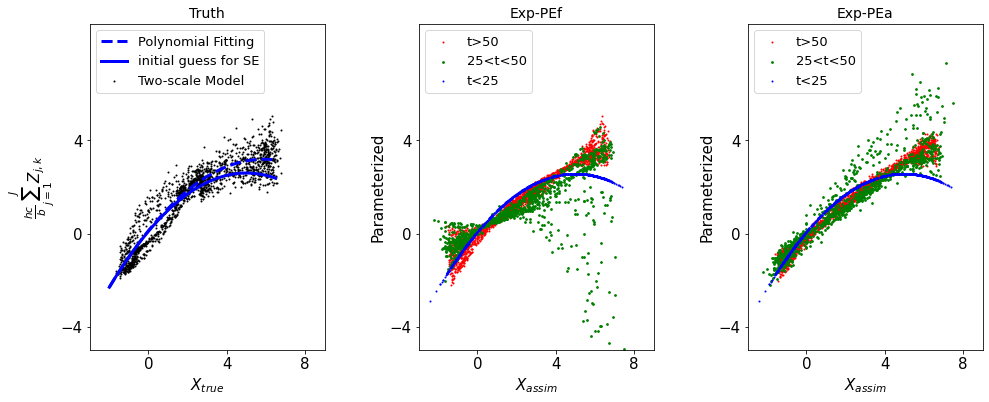

In [12]:
if True:
    TMP_DAT = np.load(case_dir+'output/pe_result_fix2.npz')
    Xassim_ana = TMP_DAT['arr_9'];PCassim_ana = TMP_DAT['arr_10']
    Yassim_ana = np.zeros_like(Xassim_ana)
    for j in range(125):
        for n in range(Ne):
            Yassim_ana[j,n]= np.polyval(pC0,Xassim_ana[j,n])     
    for j in range(125,500):
        for n in range(Ne):
            Yassim_ana[j,n] = np.polyval(PCassim_ana[j,n],Xassim_ana[j,n]) 
    meanPara1 = np.mean(Yassim_ana,axis=1)
    meanXana1 = np.mean(Xassim_ana,axis=1)
    S11 = np.std(Yassim_ana,axis=1)
    PCa1 = PCassim_ana
    #
    TMP_DAT = np.load(case_dir+'output/pe_result_adaptive2.npz')
    Xassim_ana = TMP_DAT['arr_9'];PCassim_ana = TMP_DAT['arr_10']
    Yassim_ana = np.zeros_like(Xassim_ana)
    for j in range(125):
        for n in range(Ne):
            Yassim_ana[j,n]= np.polyval(pC0,Xassim_ana[j,n])  
    for j in range(125,500):
        for n in range(Ne):
            Yassim_ana[j,n] = np.polyval(PCassim_ana[j,n],Xassim_ana[j,n]) 
    meanPara2 = np.mean(Yassim_ana,axis=1)
    meanXana2 = np.mean(Xassim_ana,axis=1)
    plt.figure(figsize=(16,6))
    plt.subplot(1,3,1)
    plt.scatter(Xu[range(0,2000,10)],Para_true[range(0,2000,10)],s=1,c='k',label='Two-scale Model')
    plt.plot(xtt,gU(xtt),'b--',lw=3,label='Polynomial Fitting')
    plt.plot(xtt,zU(xtt),'b-',lw=3,label='initial guess for SE')
    plt.ylim(-5,9);plt.xlim(-3,9)
    #for j in range(len(z)):
    #    plt.text(4,-1-j,r'$b_'+str(j)+'$=%.3f'%z[2-j]+',',fontsize=10)
    plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15);plt.xlabel(r'$X_{true}$',fontsize=15)
    plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
    plt.legend(fontsize=13,loc=2)
    plt.title('Truth',fontsize=14)
    #
    plt.subplots_adjust(wspace=0.4,hspace=0)
    plt.subplot(1,3,2)
    plt.scatter(meanXana1[range(250,500)],meanPara1[range(250,500)],s=1,c='r',label='t>50')
    plt.scatter(meanXana1[range(125,249)],meanPara1[range(125,249)],s=3,c='g',label='25<t<50')
    plt.scatter(meanXana1[range(124)],meanPara1[range(124)],s=1,c='b',label='t<25')
    plt.ylim(-5,9);plt.xlim(-3,9)
    plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
    plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
    plt.title('Exp-PEf',fontsize=14)
    plt.legend(loc=2,fontsize=13)
    plt.subplot(1,3,3)
    plt.scatter(meanXana1[range(250,500)],meanPara2[range(250,500)],s=1,c='r',label='t>50')
    plt.scatter(meanXana1[range(125,249)],meanPara2[range(125,249)],s=3,c='g',label='25<t<50')
    plt.scatter(meanXana1[range(124)],meanPara2[range(124)],s=1,c='b',label='t<25')
    plt.ylim(-5,9);plt.xlim(-3,9)
    plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
    plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
    plt.title('Exp-PEa',fontsize=14)
    plt.legend(loc=2,fontsize=13)
    #plt.savefig(case_dir+'figure7.eps',format='eps')

In [72]:
if True:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
    PCs0 = np.ones([Ne,3])
    if not os.path.exists(case_dir+'INITENS/paraensens'+str(Ne)+'.npz'):
        for j in range(Ne):      # intial perturbation of coefficients
            PCs0[j] = pC0+pCstd*np.random.randn(3)    
        np.savez(case_dir+'INITENS/paraensens'+str(Ne)+'.npz',PCs0)
    else:
        TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
        PCs0 = TMP_DAT['arr_0'];
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    para_inf = 1.02
    #
    LOC_MAT_SE = np.ones([K,K])  # no localization
    # apply localization
    local_para = 0.5
    for i in range(K):
        for j in range(K):
            dist = np.abs(i-j);
            if dist>K/2.0:
                dist=K-dist;
            LOC_MAT_SE[i,j] = comp_cov_factor(dist,local_para);
    LOC_MAT = np.ones([K,K]) 
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT_SE,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out
    # activate PE 
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            
            PCs_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = para_inf*(PCs[n]-PCs_mean)+PCs_mean
                
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)            
            # Ens_ext = eakf_analysis_constinf(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op)
            for i in range(K):                
                H_i = H_mat_ext[i,:]
                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[i],obs_error_var,H_i,LOC_MAT_ext[:,i],H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            PCs = Ens_ext[:,range(K,K+3)]
            

        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out     
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

In [73]:
print('mean RMSE = %.3f'%np.mean(rmse[500::]))
print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.169
mean RMSS = 0.104


再次对比有TVR的实验，看看不同观测个数

In [77]:
if True:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
    TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
    PCs0 = TMP_DAT['arr_0'];
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    para_inf = 1.02
    obs_dim=4
    #
    LOC_MAT_SE = np.ones([K,K])  # no localization
    # apply localization
    local_para = 0.5
    for i in range(K):
        for j in range(K):
            dist = np.abs(i-j);
            if dist>K/2.0:
                dist=K-dist;
            LOC_MAT_SE[i,j] = comp_cov_factor(dist,local_para);
            
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    INDICES = np.zeros([500,obs_dim])
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT_SE,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out
    # activate PE 
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            
            PCs_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = para_inf*(PCs[n]-PCs_mean)+PCs_mean
                
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)            
            # Ens_ext = eakf_analysis_constinf(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op)
            opt_idx=[]
            for i in range(obs_dim):
                VR = comp_vr(Ens_ext, obs_error_var, H_op, H_mat_ext)
                tvr = np.sum(VR[8::,:],axis=0)
                idx1 = max_index(tvr, opt_idx)
                opt_idx.append(idx1)
                H_i = H_mat_ext[idx1,:]

                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[idx1],obs_error_var,H_i,LOC_MAT_ext[:,idx1],H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            INDICES[tassim]=opt_idx
            PCs = Ens_ext[:,range(K,K+3)]
            

        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out     
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.171
mean RMSS = 0.109


使用不同数量的自适应观测得到的结果

| Obs = 2 | 3    | 4    |      | obs=8 |
| ------- | ---- | ---- | ---- | ----- |
| .190    | .185 | .171 |      | .169  |
| .154    | .134 | .109 |      | .104  |

说明4个挺够的了

In [78]:
if True:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.2,0.4,0.2])
    TMP_DAT = np.load(case_dir+'INITENS/paraensens'+str(Ne)+'.npz')
    PCs0 = TMP_DAT['arr_0'];
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    inf_factors = np.zeros([assim_period//obs_every_n_steps,K])
    inf_in = 1.05*np.ones(K)
    para_inf = 1.02
    #
    
    LOC_MAT_SE = np.ones([K,K])  # no localization
    # apply localization
    local_para = 0.5
    for i in range(K):
        for j in range(K):
            dist = np.abs(i-j);
            if dist>K/2.0:
                dist=K-dist;
            LOC_MAT_SE[i,j] = comp_cov_factor(dist,local_para);
            
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT_SE,inf_in,H_op); 
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out
    # activate PE 
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            inf_factors[tassim] = inf_in
            ens_mean = np.mean(Ens2,axis=0)
            
            Ens2,inf_out = eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,inf_in,H_op); 
            
            PCs_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = para_inf*(PCs[n]-PCs_mean)+PCs_mean
                
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)            
            # Ens_ext = eakf_analysis_constinf(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op)
            for i in [1,3,5,7]:                
                H_i = H_mat_ext[i,:]
                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[i],obs_error_var,H_i,LOC_MAT_ext[:,i],H_op); 
            
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            
            PCs = Ens_ext[:,range(K,K+3)]
            

        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2; inf_in = inf_out     
    rmse = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
    rmss = np.sqrt(np.mean(np.square(Xspread),axis=1))
    print('mean RMSE = %.3f'%np.mean(rmse[500::]))
    print('mean RMSS = %.3f'%np.mean(rmss[500::]))

mean RMSE = 0.169
mean RMSS = 0.123
